# Creating Winning Tickets

In this notebook we will Create Winning Tickets. To do so we safe an initial weight configuration of a CNN and compare the training performance of the configuration for basic training and training with most of the weights pruned using iterative magnitude pruning with resetting.

## A: importing libraries, data preprocessing and the CNN architecture

In [1]:
# import necessary libraries

import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# download dataset and preprocess dataset

def load_and_prep_cifar(batch_size, shuffle_size):
    # load data set
    (train_ds, test_ds), ds_info = tfds.load(name="cifar10", split=["train","test"], as_supervised=True, with_info=True)
    # tfds.show_examples(train_ds, ds_info)
    
    def prepare_cifar10_data(ds):
        #convert data from uint8 to float32
        ds = ds.map(lambda img, target: (tf.cast(img, tf.float32), target))
        #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
        ds = ds.map(lambda img, target: ((img/128.)-1., target))
        #create one-hot targets
        ds = ds.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
        #cache this progress in memory, as there is no need to redo it; it is deterministic after all
        ds = ds.cache()
        #shuffle, batch, prefetch
        ds = ds.shuffle(shuffle_size).batch(batch_size).prefetch(2)
        #return preprocessed dataset
        return ds
    
    # prepare data
    train_dataset = train_ds.apply(prepare_cifar10_data)
    test_dataset = test_ds.apply(prepare_cifar10_data)
    
    return train_dataset, test_dataset

In [3]:
# create the model

class CNN2Model(tf.keras.Model):
    
    # basic
    def __init__(self):
        super(CNN2Model, self).__init__()
        
        # set biases to a value that is not exactly 0.0, so they don't get handled like pruned values
        self.bias_in = tf.keras.initializers.Constant(value=0.0000000001)
        
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation="relu", padding="same",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batchsize,32,32,64]
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation="relu", padding="same",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batchsize,32,32,64]
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2),input_shape=(32, 32, 64)) # [batchsize,16,16,64]
        self.flatten = tf.keras.layers.Flatten() # [batch_size,16384]
        self.dense1 = tf.keras.layers.Dense(256, activation="relu",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]
        self.dense2 = tf.keras.layers.Dense(256, activation="relu",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]
        self.dense3 = tf.keras.layers.Dense(10, activation="softmax",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]

    @tf.function
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x
            
    
    def get_conv_weights(self):
        return self.conv1.get_weights(), self.conv2.get_weights(), self.dense3.get_weights()
        
    def set_conv_weights(self,weights_conv1, weights_conv2, weights_dense3):
        self.conv1.set_weights(weights_conv1)
        self.conv2.set_weights(weights_conv2)
        self.dense3.set_weights(weights_dense3)
        
    def get_dense_weights(self):
        return self.dense1.get_weights(), self.dense2.get_weights()
        
    def set_dense_weights(self,weights_dense1, weights_dense2):
        self.dense1.set_weights(weights_dense1)
        self.dense2.set_weights(weights_dense2)

## B: Three types of Training loops

One Trianing Loop for basic training, one for iterative magnitude pruning with resetting and one for basic training of a sparse network.  
For iterative magnitude pruning with resetting after x epochs of trianing the p weights with the smallest magnitudes are set to zero. p depends on the layer. weights with a value of zero are then excluded from further optimization. All other weights are resetted to their initial value and then this process is repeated several times.  
Taining of a sparse network is similar to the basic training with the difference that weights with a value of 0 are excluded from training.
There is also a plotting funtion to show loss and accuracy for training and testing.

In [4]:
# basic train loop

def train_loop(train, test, model, num_epochs):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
    loss_function= tf.keras.losses.CategoricalCrossentropy()
    
    train_accuracy = tf.keras.metrics.Accuracy(name='test_accuracy')
    test_accuracy = tf.keras.metrics.Accuracy(name='train_accuracy')
    train_losses = tf.keras.metrics.CategoricalCrossentropy(name='train_losses')
    test_losses = tf.keras.metrics.CategoricalCrossentropy(name='test_losses')
    train_acc = []
    test_acc = []
    train_l =[]
    test_l = []

    for e in tqdm(range(num_epochs)):
        
        #train step
        for x, t in train:
            with tf.GradientTape() as tape:
                pred = model(x)
                loss = loss_function(t, pred)
                train_losses.update_state(t, pred)
                train_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
        # test step
        for x, t in test:
            pred = model(x)
            test_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
            test_losses.update_state(t, pred)
        
        train_acc.append(train_accuracy.result().numpy())
        test_acc.append(test_accuracy.result().numpy())
        train_l.append(train_losses.result().numpy())
        test_l.append(test_losses.result().numpy())
        train_accuracy.reset_state()
        test_accuracy.reset_state()
        train_losses.reset_state()
        test_losses.reset_state()     
    
    return  train_acc, test_acc, train_l, test_l

In [5]:
# train loop of iterative magnitude pruning

def train_loop_imp(train, test, model, pruning_rounds=10, num_epochs_per_pruning=10, pruning_rate_conv=10, pruning_rate_dense=20):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
    loss_function= tf.keras.losses.CategoricalCrossentropy()
    
    train_accuracy = tf.keras.metrics.Accuracy(name='test_accuracy')
    test_accuracy = tf.keras.metrics.Accuracy(name='train_accuracy')
    train_losses = tf.keras.metrics.CategoricalCrossentropy(name='train_losses')
    test_losses = tf.keras.metrics.CategoricalCrossentropy(name='test_losses')
    train_acc = []
    test_acc = []
    train_l =[]
    test_l = []
    
    # safe initial weights for conv layers (and last layer, because they share the same pruning rate)
    conv_initial_weights = []
    for weight_matrix in model.get_conv_weights():
        conv_initial_weights.append(weight_matrix)
        
    # safe initial weights for dense layers
    dense_initial_weights = []
    for weight_matrix in model.get_dense_weights():
        dense_initial_weights.append(weight_matrix)
        
        
    for r in tqdm(range(pruning_rounds)):
    
        for e in tqdm(range(num_epochs_per_pruning)):

            #train step
            for x, t in train:
                with tf.GradientTape() as tape:
                    pred = model(x)
                    loss = loss_function(t, pred)
                    train_losses.update_state(t, pred)
                    train_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
                gradients = tape.gradient(loss, model.trainable_variables)
                # set gradients to zero for all pruned weights
                for gradient_matrix, variables in zip(gradients, model.trainable_variables):
                    gradient_matrix = np.where(variables == 0.0, 0.0, gradient_matrix)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # test step
            for x, t in test:
                pred = model(x)
                test_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
                test_losses.update_state(t, pred)

            train_acc.append(train_accuracy.result().numpy())
            test_acc.append(test_accuracy.result().numpy())
            train_l.append(train_losses.result().numpy())
            test_l.append(test_losses.result().numpy())
            train_accuracy.reset_state()
            test_accuracy.reset_state()
            train_losses.reset_state()
            test_losses.reset_state()

        # at end of each round, prune the smallest weights(not including biases) by setting them to zero 
        # and reset all other weights to their initial value   
        
        new_conv_weights = []   
        for weight_matrix, init_weights in zip(model.get_conv_weights(), conv_initial_weights):
            # calculate the percentile
            percentile = np.percentile(np.abs(weight_matrix[0][weight_matrix[0] != 0.0].flatten()), pruning_rate_conv,)
            # set pruned weights to zero and reset other weights
            new_conv_weights.append([np.where(weight_matrix[0] < percentile, 0, init_weights[0]), init_weights[1]])
        model.set_conv_weights(new_conv_weights[0], new_conv_weights[1], new_conv_weights[2])
        
        new_dense_weights = []
        for weight_matrix, init_weights in zip(model.get_dense_weights(), dense_initial_weights):
            # calculate the percentile
            percentile = np.percentile(np.abs(weight_matrix[0][weight_matrix[0] != 0.0].flatten()), pruning_rate_dense,)
            # set pruned weights to zero  and reset other weights
            new_dense_weights.append([np.where(weight_matrix[0] < percentile, 0, init_weights[0]), init_weights[1]])
        model.set_dense_weights(new_dense_weights[0], new_dense_weights[1])
            
    
    return  train_acc, test_acc, train_l, test_l

In [6]:
# train loop for sparse networks

def train_loop_sparse(train, test, model, num_epochs):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
    loss_function= tf.keras.losses.CategoricalCrossentropy()
    
    train_accuracy = tf.keras.metrics.Accuracy(name='test_accuracy')
    test_accuracy = tf.keras.metrics.Accuracy(name='train_accuracy')
    train_losses = tf.keras.metrics.CategoricalCrossentropy(name='train_losses')
    test_losses = tf.keras.metrics.CategoricalCrossentropy(name='test_losses')
    train_acc = []
    test_acc = []
    train_l =[]
    test_l = []

    for e in tqdm(range(num_epochs)):
        
        #train step
        for x, t in train:
            with tf.GradientTape() as tape:
                pred = model(x)
                loss = loss_function(t, pred)
                train_losses.update_state(t, pred)
                train_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
            gradients = tape.gradient(loss, model.trainable_variables)
            # set gradients to zero for all pruned weights
            for gradient_matrix, variables in zip(gradients, model.trainable_variables):
                gradient_matrix = np.where(variables == 0.0, 0.0, gradient_matrix)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
        # test step
        for x, t in test:
            pred = model(x)
            test_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
            test_losses.update_state(t, pred)
        
        train_acc.append(train_accuracy.result().numpy())
        test_acc.append(test_accuracy.result().numpy())
        train_l.append(train_losses.result().numpy())
        test_l.append(test_losses.result().numpy())
        train_accuracy.reset_state()
        test_accuracy.reset_state()
        train_losses.reset_state()
        test_losses.reset_state()     
    
    return  train_acc, test_acc, train_l, test_l

In [7]:
# plot the results

def plot_losses(train_acc, test_acc, train_l, test_l, title):
    fig= plt.figure(figsize=(10,6))
    plt.title(title)
    plt.xlabel("epochs")
    plt.ylabel("Loss/Accuracy")
    plt.plot(test_l,label="test loss")
    plt.plot(train_l,label="training loss")
    plt.plot(test_acc,label="test accuracy")
    plt.plot(train_acc,label="training accuracy")
    plt.legend()
    plt.show()

    max_test_acc_control = np.max(test_acc)
    min_test_loss_control = np.min(test_l)
    print(f"lowest testing loss: {min_test_loss_control}")
    print(f"highest testing accuracy: {max_test_acc_control}")

## C: Putting it all togethter

1. getting the initial weight configuration
2. trianing the control model with the initial weights and storing the testing accuracy
3. performing iterative magnitude pruning with resetting on the initial weight configuration and storing the resulting sparse network configuration
4. train the resulting sparse network from the start and get the testing accuracy

In [8]:
# function to create sparse networks

def create_sparse_net(train_dataset, test_dataset):
    #########################################
    # 1.:  get initial weight configuration #
    #########################################

    model = CNN2Model()

    #predict something with the model so it initializes the weights
    model(list(train_dataset)[0][0])

    #save the initial weights to reuse for IMP
    conv_initial_weights = []
    for weight_matrix in model.get_conv_weights():
        conv_initial_weights.append(weight_matrix)
    dense_initial_weights = []
    for weight_matrix in model.get_dense_weights():
        dense_initial_weights.append(weight_matrix)
        
    #########################################################################
    # 2.:  train control model with initial weights to get control accuracy #
    #########################################################################

    control_model = CNN2Model()
    control_model(list(train_dataset)[0][0])
    control_model.set_conv_weights(conv_initial_weights[0], conv_initial_weights[1], conv_initial_weights[2])
    control_model.set_dense_weights(dense_initial_weights[0], dense_initial_weights[1])

    train_acc, test_acc, train_l, test_l = train_loop(train_dataset, test_dataset, control_model, num_epochs=5)
    control_stats = [train_acc, test_acc, train_l, test_l]
    plot_losses(train_acc, test_acc, train_l, test_l,"CNN Loss and Accuracy for control model")
    
    #######################################################################################
    # 3.:  use initial weights to also perform iterative magnitude pruning on a new model #
    #######################################################################################

    imp_model = CNN2Model()
    imp_model(list(train_dataset)[0][0])
    imp_model.set_conv_weights(conv_initial_weights[0], conv_initial_weights[1], conv_initial_weights[2])
    imp_model.set_dense_weights(dense_initial_weights[0], dense_initial_weights[1])

    train_acc, test_acc, train_l, test_l = train_loop_imp(train_dataset, test_dataset, imp_model)
    imp_stats = [train_acc, test_acc, train_l, test_l]
    plot_losses(train_acc, test_acc, train_l, test_l,"CNN Loss and Accuracy for iterative magnitude pruning")

    #get resulting sparse network weights
    conv_sparse_weights = []
    for weight_matrix in imp_model.get_conv_weights():
        conv_sparse_weights.append(weight_matrix)
    dense_sparse_weights = []
    for weight_matrix in imp_model.get_dense_weights():
        dense_sparse_weights.append(weight_matrix)
        
    #############################################################################
    # 4.:  train the resulting sparse network from the start and get accuracies #
    #############################################################################

    sparse_model = CNN2Model()
    sparse_model(list(train_dataset)[0][0])
    sparse_model.set_conv_weights(conv_sparse_weights[0], conv_sparse_weights[1], conv_sparse_weights[2])
    sparse_model.set_dense_weights(dense_sparse_weights[0], dense_sparse_weights[1])

    train_acc, test_acc, train_l, test_l = train_loop_sparse(train_dataset, test_dataset, sparse_model, num_epochs=5)
    sparse_stats = [train_acc, test_acc, train_l, test_l]
    plot_losses(train_acc, test_acc, train_l, test_l,"CNN Loss and Accuracy for sparse network")
    
    return control_stats, sparse_stats, conv_sparse_weights, dense_sparse_weights, imp_model

## D: create multiple Winning Tickets and store their weight configuration in a file

5. check if sparse network is a Winning Ticket by comparing accuracy with accurcy of control model
6. do this multiple times to create a bunch of winning tickets

In [9]:
def create_lottery_tickets(runs):
    
    # get dataset
    train_dataset, test_dataset = load_and_prep_cifar(batch_size=60, shuffle_size=512)
    
    for r in range(runs):
        
        # create sparse network
        control_stats, sparse_stats, conv_sparse_weights, dense_sparse_weights, imp_model = create_sparse_net(train_dataset, test_dataset)
        control_accuracy = np.max(control_stats[1])
        sparse_accuracy = np.max(sparse_stats[1])
        print("Best accuracy of control model: ", control_accuracy)
        print("Best accuracy of sparse model: ", sparse_accuracy)
        
        # calculate percentage of pruned weights
        all_weights = imp_model.get_weights()
        int_weights = []
        for w in all_weights:
            int_weights.extend(w.astype(bool).astype(int).flatten())
        pruned_amount = np.mean(int_weights)
        print(f"The sparse model is pruned to {pruned_amount} of its original size")
        
        #safe winning ticket
        imp_model.save_weights(f"./own_wts/sparse_net{r}", save_format="h5")
        
        # compare accuracy to check wheter sparse network is winning ticket
        if sparse_accuracy >= control_accuracy:
            print("It's a winning ticket!")
        else:
            print("It's not a winning ticket.")
        

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [09:15<00:00, 111.05s/it]


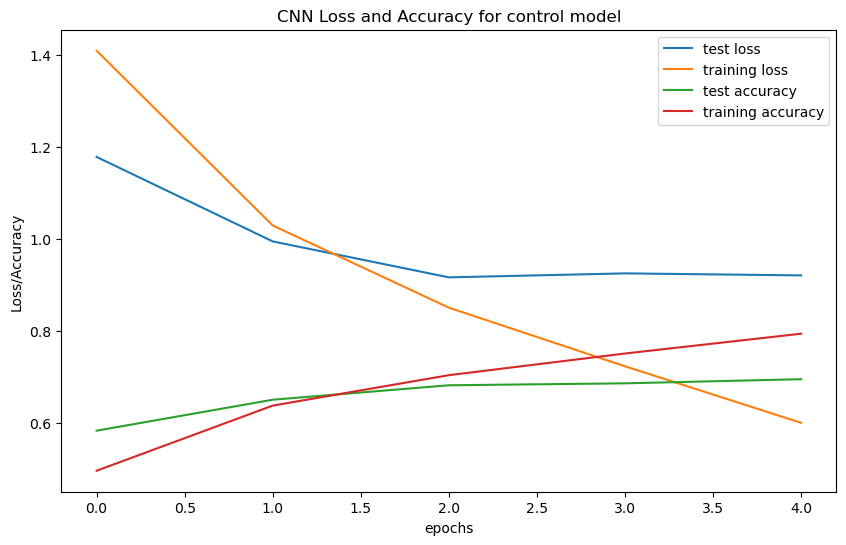

lowest testing loss: 0.9162741899490356
highest testing accuracy: 0.6951000094413757


 40%|████████████████████████████████▊                                                 | 4/10 [08:12<12:18, 123.12s/it]


100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [3:25:16<00:00, 1231.64s/it]


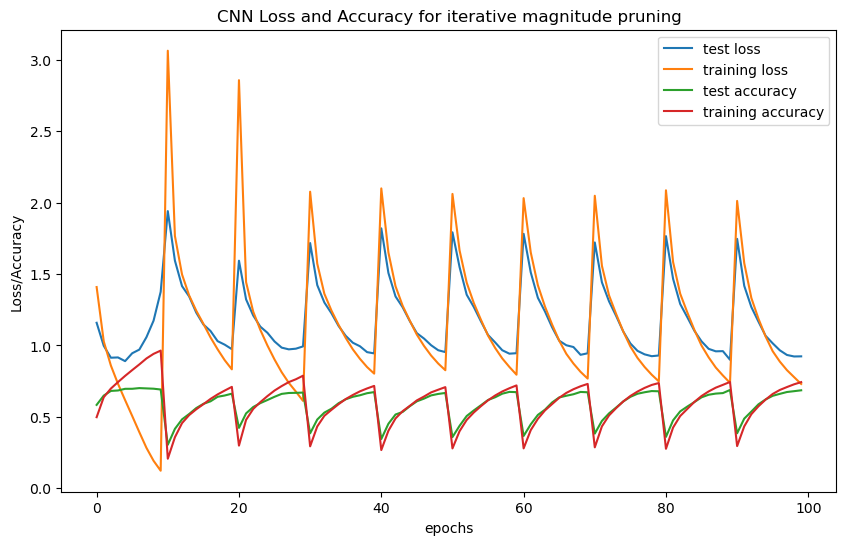

lowest testing loss: 0.8904063701629639
highest testing accuracy: 0.7016000151634216


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:13<00:00, 122.68s/it]


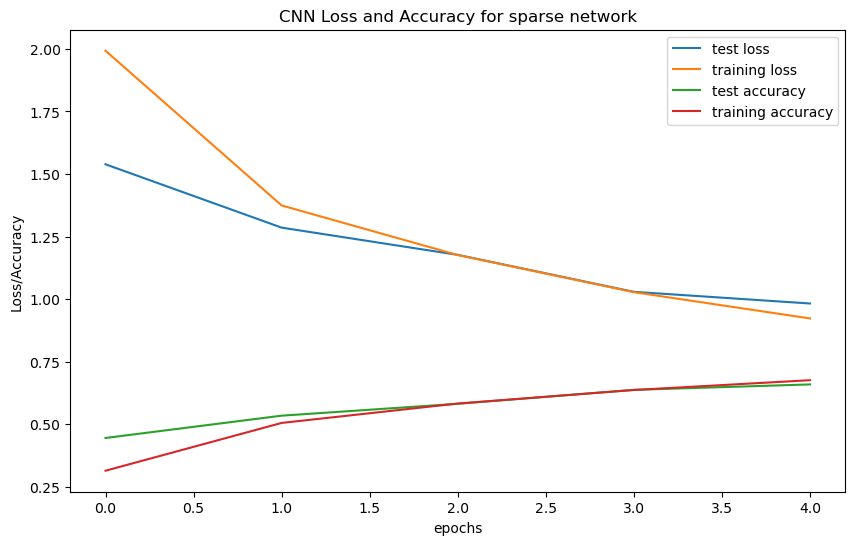

lowest testing loss: 0.9823700189590454
highest testing accuracy: 0.6589000225067139
Best accuracy of control model:  0.6951
Best accuracy of sparse model:  0.6589
The sparse model is pruned to 0.07626366861770459 of its original size
It's not a winning ticket.


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [09:16<00:00, 111.39s/it]


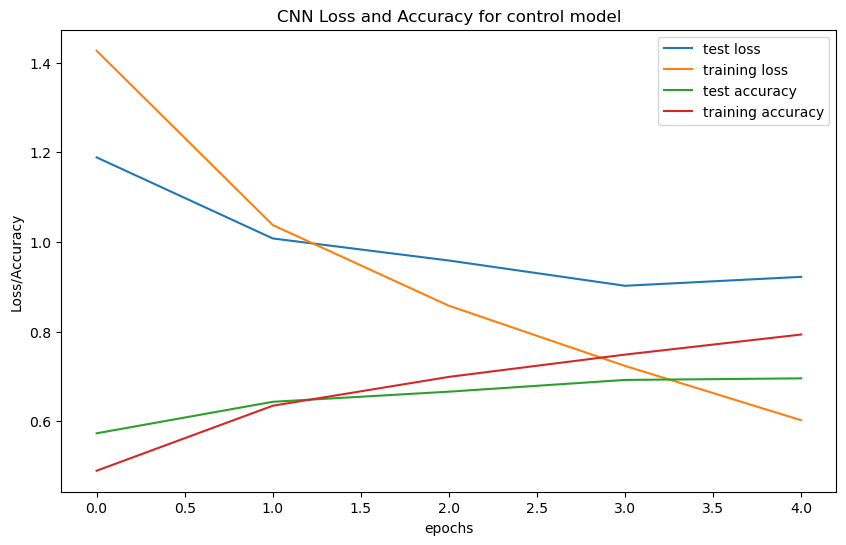

lowest testing loss: 0.902277946472168
highest testing accuracy: 0.6956999897956848


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

In [ ]:
create_lottery_tickets(3)